In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import haversine as hs
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, TransformerConv,PDNConv,SuperGATConv,GATv2Conv
seed = 42
random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = xr.open_dataset("data/delhi_cpcb_2022.nc")

In [2]:
df_ = data.to_dataframe().reset_index()


df = df_[df_["time"]=="2022-05-01 01:30:00"]
df = df.dropna(subset=['PM2.5'])
le = LabelEncoder()
df['station_le'] = le.fit_transform(df['station'])



In [3]:
df

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude,station_le
2881,"Alipur, Delhi - DPCC",2022-05-01 01:30:00,2022-05-01 01:00:00,2022-05-01 02:00:00,175.00,NaN,80.33,57.05,95.88,20.38,...,NaN,45.27,4.50,976.85,26.55,0.0,0.0,28.815329,77.153010,0
11664,"Anand Vihar, Delhi - DPCC",2022-05-01 01:30:00,2022-05-01 01:00:00,2022-05-01 02:00:00,227.00,776.50,NaN,NaN,NaN,NaN,...,0.30,178.75,9.10,972.38,32.77,NaN,0.0,28.647622,77.315809,1
20447,"Ashok Vihar, Delhi - DPCC",2022-05-01 01:30:00,2022-05-01 01:00:00,2022-05-01 02:00:00,167.00,396.75,223.83,80.32,225.30,28.17,...,0.33,128.45,5.88,970.73,33.40,0.0,0.0,28.695381,77.181665,2
29230,"Aya Nagar, Delhi - IMD",2022-05-01 01:30:00,2022-05-01 01:00:00,2022-05-01 02:00:00,73.26,187.93,20.77,26.02,46.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936,3
38013,"Bawana, Delhi - DPCC",2022-05-01 01:30:00,2022-05-01 01:00:00,2022-05-01 02:00:00,179.25,540.00,123.70,33.35,157.05,32.60,...,0.52,204.48,5.62,976.52,28.45,0.0,0.0,28.776200,77.051074,4
46796,"Burari Crossing, Delhi - IMD",2022-05-01 01:30:00,2022-05-01 01:00:00,2022-05-01 02:00:00,146.25,360.52,23.95,13.18,37.14,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.725650,77.201157,5
55579,"CRRI Mathura Road, Delhi - IMD",2022-05-01 01:30:00,2022-05-01 01:00:00,2022-05-01 02:00:00,148.67,461.48,96.61,17.41,113.98,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.551201,77.273574,6
64362,"Chandni Chowk, Delhi - IITM",2022-05-01 01:30:00,2022-05-01 01:00:00,2022-05-01 02:00:00,160.70,494.57,9.28,14.31,14.92,5.95,...,2.11,292.77,NaN,NaN,37.28,0.0,0.0,28.656756,77.227234,7
81928,"Dr. Karni Singh Shooting Range, Delhi - DPCC",2022-05-01 01:30:00,2022-05-01 01:00:00,2022-05-01 02:00:00,120.75,321.75,61.20,102.28,104.25,27.90,...,0.30,133.07,5.22,971.95,29.30,0.0,0.0,28.498571,77.264840,8
90711,"Dwarka-Sector 8, Delhi - DPCC",2022-05-01 01:30:00,2022-05-01 01:00:00,2022-05-01 02:00:00,95.75,378.25,171.35,54.65,225.70,40.23,...,0.65,127.90,5.12,974.20,31.75,0.0,0.0,28.571027,77.071901,9


In [4]:
station = {}
lat = []
long = []
for i in df.station_le.unique():
    lat_i = df[df['station_le'] == i]['latitude'].item()
    long_i = df[df['station_le'] == i]['longitude'].item()
    pm_i = df[df['station_le'] == i]['PM2.5'].item()
    s_name = df[df['station_le'] == i]['station'].item()
    # co = df_impute[df_impute['station'] == i]['CO']
    
    
    station[i] = [lat_i, long_i, pm_i,s_name]
    long.append(long_i)
    lat.append(lat_i)

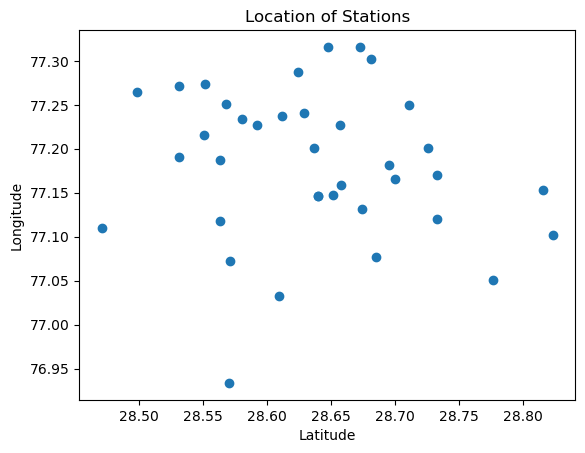

In [5]:
plt.scatter(y = long, x = lat)
plt.title('Location of Stations')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

In [6]:
station

{0: [28.815329, 77.15301, 175.0, 'Alipur, Delhi - DPCC'],
 1: [28.647622, 77.315809, 227.0, 'Anand Vihar, Delhi - DPCC'],
 2: [28.695381, 77.181665, 167.0, 'Ashok Vihar, Delhi - DPCC'],
 3: [28.4706914, 77.1099364, 73.26, 'Aya Nagar, Delhi - IMD'],
 4: [28.7762, 77.051074, 179.25, 'Bawana, Delhi - DPCC'],
 5: [28.7256504, 77.2011573, 146.25, 'Burari Crossing, Delhi - IMD'],
 6: [28.5512005, 77.2735737, 148.67, 'CRRI Mathura Road, Delhi - IMD'],
 7: [28.656756, 77.227234, 160.7, 'Chandni Chowk, Delhi - IITM'],
 8: [28.498571,
  77.26484,
  120.75,
  'Dr. Karni Singh Shooting Range, Delhi - DPCC'],
 9: [28.5710274, 77.0719006, 95.75, 'Dwarka-Sector 8, Delhi - DPCC '],
 10: [28.5627763, 77.1180053, 170.7, 'IGI Airport (T3), Delhi - IMD'],
 11: [28.6811736, 77.3025234, 179.22, 'IHBAS, Dilshad Garden, Delhi - CPCB'],
 12: [28.628624, 77.24106, 139.25, 'ITO, Delhi - CPCB'],
 13: [28.73282, 77.170633, 171.33, 'Jahangirpuri, Delhi - DPCC'],
 14: [28.58028, 77.233829, 110.0, 'Jawaharlal Nehru S

In [7]:
def get_distance(lat1, lon1, lat2, lon2):
    # Calculate the distance between the coordinates using the Haversine formula
    return hs.haversine((lat1, lon1), (lat2, lon2))

distances = [] #Store distance between each pair of nodes
for i in station.keys():
    temp = []
    for j in station.keys():
        if i==j:
            continue
        else:
            temp.append([get_distance(station[i][0], station[i][1], station[j][0], station[j][1]), j])
    distances.append(temp)


In [8]:
for i in range(len(distances)):
    distances[i].sort()

In [9]:
import networkx as nx

no_of_neighbours = 8

G = nx.Graph()

for i in station.keys():
    G.add_node(i, latitude = station[i][0], longitude = station[i][1], pm = station[i][2], station = station[i][3])
    
    for j in range(no_of_neighbours): #Add edge connecting nodes closest to current node
        s = distances[i][j][1]
        G.add_node(s, latitude = station[s][0], longitude = station[s][1], pm = station[s][2])
        G.add_edge(i, s)


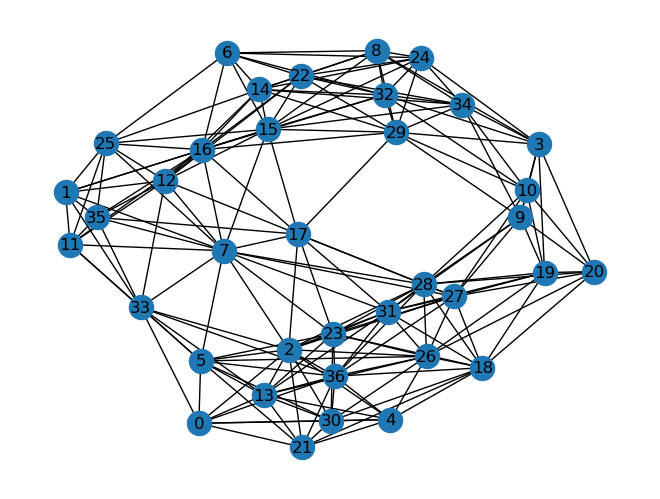

In [10]:
layout1 = nx.spring_layout(G, k=0.5)

# Draw the graph with the specified layout
plt.figure()  
nx.draw(G, pos=layout1, with_labels=True)
plt.show()

In [11]:
node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
edge_index = torch.tensor(list(G.edges)).t().contiguous()
y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)

In [12]:
y.t().squeeze()

tensor([175.0000, 187.2500, 171.3300, 156.0000, 179.2500, 146.2500, 217.2500,
        167.0000, 250.5000, 227.0000, 200.7500, 156.5000, 179.2200, 139.2500,
        141.7500, 160.7000,  76.1900, 138.6500, 136.0000,  35.2300, 101.0000,
         73.2600, 170.7000, 124.5000,  95.7500, 110.5000, 122.5000, 120.7500,
        127.7500,  80.5000, 297.2500, 148.6700, 130.5000, 110.0000,  61.2500,
         25.5700, 130.0000])

In [13]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 10)
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [14]:
G.nodes[0]

{'latitude': 28.815329,
 'longitude': 77.15301,
 'pm': 175.0,
 'station': 'Alipur, Delhi - DPCC'}

In [15]:
dataframe = []

In [16]:

#GNN
def run_model(G):
    node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
    for super in list(G.nodes()):
        # print(super)
        # sorted_nodes = sorted(G.nodes(), key=lambda node: G.nodes[node]['latitude'])

        # Divide train and test masks based on the latitudes
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        test_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for j, node in list(enumerate(G.nodes)):
            # lat = G.nodes[node]['latitude']
            # if lat in lat_list[:30]:
            #     train_mask[i] = True
            # else:
            #     test_mask[i] = True
            if node!=super:
                train_mask[j] = True
            else:
                test_mask[j] = True

        data1 = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)
        model1 = RegressionModel(input_dim=2).to(device)
        optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        
        #Train GNN
        for epoch in range(2500):
            optimizer.zero_grad()
            out = model1(data1.x.to(device), data1.edge_index.to(device))
            loss = criterion(out[data1.train_mask].squeeze(), data1.y[data1.train_mask].squeeze())
            loss.backward()
            optimizer.step()
        
        #GNN Output
        model1.eval()
        with torch.no_grad():
            out = model1(data1.x.to(device), data1.edge_index.to(device))  # Predicted PM values
            train_rmse_g = torch.sqrt(torch.mean((out[data1.train_mask].squeeze() - data1.y[data1.train_mask].squeeze())**2))
            test_rmse_g = torch.sqrt(torch.mean((out[data1.test_mask].squeeze() - data1.y[data1.test_mask].squeeze())**2))

        g_pred = out[data1.test_mask].squeeze().tolist()
        actual = data1.y[data1.test_mask].squeeze().tolist()
        # actual = G.nodes[i]["pm"]
        # print(test_mask)
        #Mean Value
        train_mean = torch.mean(data1.y[data1.train_mask])
        mean_pred = int(data1.test_mask.sum())*[float(train_mean)]
        mean_rmse_test = torch.sqrt(torch.mean((train_mean - data1.y[data1.test_mask].squeeze())**2))
        
        #Prepare Data for LR and RF
        X_train = data1.x[data1.train_mask].numpy()
        y_train = data1.y[data1.train_mask].numpy().reshape(-1)
        X_test = data1.x[data1.test_mask].numpy()
        y_test = data1.y[data1.test_mask].numpy().reshape(-1)
        # print(y_train.shape)
        #Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        y_test_pred_lr = lr_model.predict(X_test)
        test_rmse_lr = torch.sqrt(torch.mean((torch.tensor(y_test_pred_lr) - data1.y[data1.test_mask])**2))

        #Random Forest
        rf_model = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
        rf_model.fit(X_train, y_train)
        y_test_pred_rf = rf_model.predict(X_test)
        test_rmse_rf = torch.sqrt(torch.mean((torch.tensor(y_test_pred_rf) - data1.y[data1.test_mask])**2))
        
        #KNN
        knn_model = KNeighborsRegressor(n_neighbors = 8,n_jobs=-1)
        knn_model.fit(X_train, y_train)
        y_test_pred_knn = knn_model.predict(X_test)
        test_rmse_knn = torch.sqrt(torch.mean((torch.tensor(y_test_pred_knn) - data1.y[data1.test_mask])**2))
        
        #idw
        idw_model = KNeighborsRegressor(weights = 'distance',n_jobs=-1)
        idw_model.fit(X_train, y_train)
        y_test_pred_idw = idw_model.predict(X_test)
        test_rmse_idw = torch.sqrt(torch.mean((torch.tensor(y_test_pred_idw) - data1.y[data1.test_mask])**2))
        dataframe.append({
                            "node": G.nodes[super]["station"],
                            "lat": G.nodes[super]["latitude"],
                            "lon": G.nodes[super]["longitude"],
                            "pm": G.nodes[super]["pm"],
                            "knn rmse": float(test_rmse_knn),
                            "mean rmse": float(mean_rmse_test),
                            "idw rmse": float(test_rmse_idw),
                            "lr rmse": float(test_rmse_lr),
                            "rf rmse": float(test_rmse_rf),
                            "gnn rmse": float(test_rmse_g),
                            "actual": actual,
                            "knn pred": y_test_pred_knn[0],
                            "mean pred": mean_pred[0],
                            "idw pred": y_test_pred_idw[0],
                            "lr pred": y_test_pred_lr[0],
                            "rf pred": y_test_pred_rf[0],
                            "gnn pred": g_pred,    
                           })

        # return float(test_rmse_knn), float(mean_rmse_test), float(test_rmse_lr), float(test_rmse_rf), float(test_rmse_g), g_pred, y_test_pred_rf, actual, y_test_pred_lr, mean_pred, y_test_pred_knn
        print("hello",super)    

In [17]:
#Set Timestamps
p = pd.date_range(start='2022-02-10 01:30:00', end='2022-08-15 01:30:00', freq = '12H').to_frame(name='dates')

run_model(G)

hello 0
hello 21
hello 13
hello 30
hello 4
hello 5
hello 36
hello 2
hello 33
hello 1
hello 35
hello 25
hello 11
hello 12
hello 16
hello 7
hello 15
hello 23
hello 26
hello 31
hello 17
hello 3
hello 10
hello 34
hello 9
hello 29
hello 32
hello 8
hello 24
hello 19
hello 18
hello 6
hello 22
hello 14
hello 27
hello 28
hello 20


In [18]:
df_results = pd.DataFrame(dataframe)

In [19]:
df_results

,node,lat,lon,pm,knn rmse,mean rmse,idw rmse,lr rmse,rf rmse,gnn rmse,actual,knn pred,mean pred,idw pred,lr pred,rf pred,gnn pred
0,"Alipur, Delhi - DPCC",28.815329,77.153010,175.00,9.353760,33.429993,4.274010,27.744141,2.891020,49.385307,175.000000,184.353760,141.570007,170.725990,202.744141,177.891020,125.614693
1,"Narela, Delhi - DPCC",28.822836,77.101981,187.25,1.416260,46.020279,10.145341,7.332031,3.262840,61.547951,187.250000,188.666260,141.229721,177.104659,194.582031,183.987160,125.702049
2,"Jahangirpuri, Delhi - DPCC",28.732820,77.170633,171.33,2.001251,29.658066,2.787448,2.041092,4.394718,29.790482,171.330002,173.331253,141.671936,168.542554,173.371094,175.724720,141.539520
3,"Rohini, Delhi - DPCC",28.732528,77.119920,156.00,25.622498,13.902222,40.601074,10.246094,21.429740,18.166351,156.000000,181.622498,142.097778,196.601074,166.246094,177.429740,137.833649
4,"Bawana, Delhi - DPCC",28.776200,77.051074,179.25,9.135010,37.798050,17.892559,11.062500,62.705030,41.660706,179.250000,188.385010,141.451950,197.142559,168.187500,241.955030,137.589294
5,"Burari Crossing, Delhi - IMD",28.725650,77.201157,146.25,28.428741,3.881393,45.312984,31.130859,26.445900,3.432510,146.250000,174.678741,142.368607,191.562984,177.380859,172.695900,142.817490
6,"Wazirpur, Delhi - DPCC",28.699793,77.165453,217.25,90.786255,76.853607,61.104275,58.458984,49.288940,78.402252,217.250000,126.463745,140.396393,156.145725,158.791016,167.961060,138.847748
7,"Ashok Vihar, Delhi - DPCC",28.695381,77.181665,167.00,28.698761,25.207779,8.619199,4.937500,33.975460,28.401154,167.000000,138.301239,141.792221,175.619199,162.062500,200.975460,138.598846
8,"Sonia Vihar, Delhi - DPCC",28.710508,77.249485,250.50,77.781250,111.027222,81.927221,78.681641,75.777520,111.142563,250.500000,172.718750,139.472778,168.572779,171.818359,174.722480,139.357437
9,"Anand Vihar, Delhi - DPCC",28.647622,77.315809,227.00,57.103760,86.874451,53.572259,67.384766,124.549083,88.553940,227.000000,169.896240,140.125549,173.427741,159.615234,102.450917,138.446060


In [20]:
print('KNN RMSE: ', np.mean(df_results['knn rmse']))
print('Mean RMSE: ', np.mean(df_results['mean rmse']))
print('IDW RMSE: ', np.mean(df_results['idw rmse']))
print('RF RMSE: ', np.mean(df_results['rf rmse']))
print('LR RMSE: ', np.mean(df_results['lr rmse']))
print('GNN RMSE: ', np.mean(df_results['gnn rmse']))

KNN RMSE:  32.87905553869299
Mean RMSE:  42.698349411423145
IDW RMSE:  33.87168031844755
RF RMSE:  33.023780603335176
LR RMSE:  33.224066656989024
GNN RMSE:  45.940999005291914


/var/folders/jk/w0z8m7r15qz2bq604dfvr16h0000gn/T/ipykernel_80566/833514724.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["pm"], cmap = "jet")


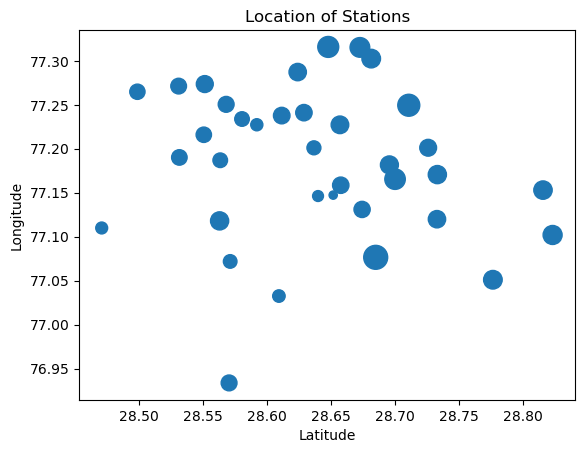

In [23]:
plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["pm"], cmap = "jet")
plt.title('Location of Stations')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

In [24]:
df_results.columns

Index(['node', 'lat', 'lon', 'pm', 'knn rmse', 'mean rmse', 'idw rmse',
       'lr rmse', 'rf rmse', 'gnn rmse', 'actual', 'knn pred', 'mean pred',
       'idw pred', 'lr pred', 'rf pred', 'gnn pred'],
      dtype='object')

/var/folders/jk/w0z8m7r15qz2bq604dfvr16h0000gn/T/ipykernel_80566/2735186990.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["gnn rmse"], cmap = "jet")


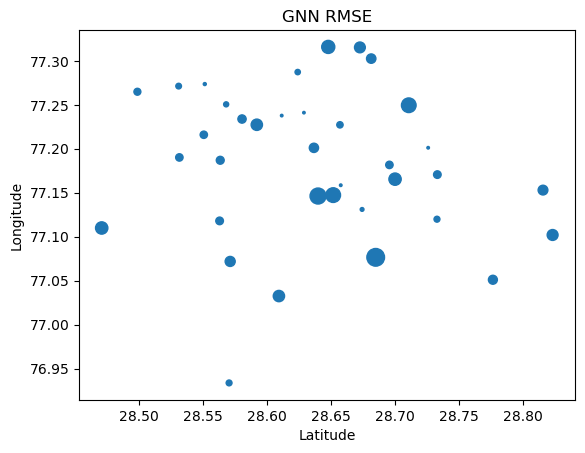

In [31]:
plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["gnn rmse"], cmap = "jet")
plt.title('GNN RMSE')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

/var/folders/jk/w0z8m7r15qz2bq604dfvr16h0000gn/T/ipykernel_80566/23401796.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["knn rmse"], cmap = "jet")


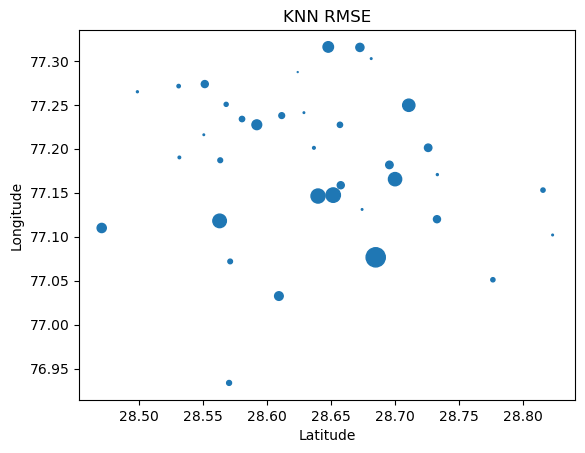

In [32]:
plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["knn rmse"], cmap = "jet")
plt.title('KNN RMSE')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

/var/folders/jk/w0z8m7r15qz2bq604dfvr16h0000gn/T/ipykernel_80566/637009923.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["lr rmse"], cmap = "jet")


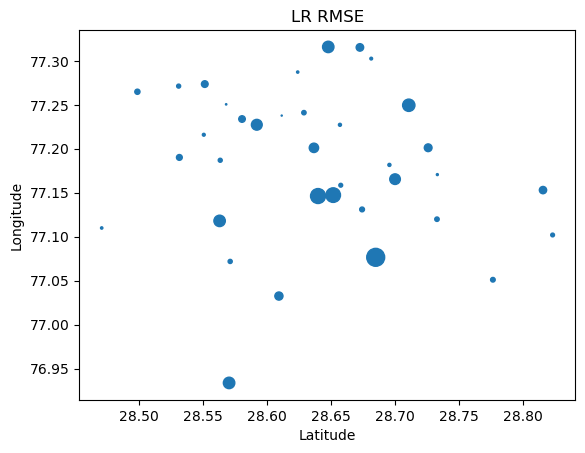

In [33]:
plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["lr rmse"], cmap = "jet")
plt.title('LR RMSE')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

/var/folders/jk/w0z8m7r15qz2bq604dfvr16h0000gn/T/ipykernel_80566/2885045887.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["rf rmse"], cmap = "jet")


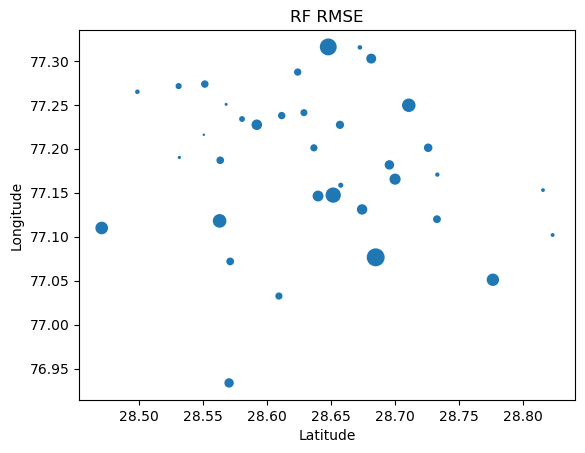

In [34]:
plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["rf rmse"], cmap = "jet")
plt.title('RF RMSE')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

/var/folders/jk/w0z8m7r15qz2bq604dfvr16h0000gn/T/ipykernel_80566/509225339.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["idw rmse"], cmap = "jet")


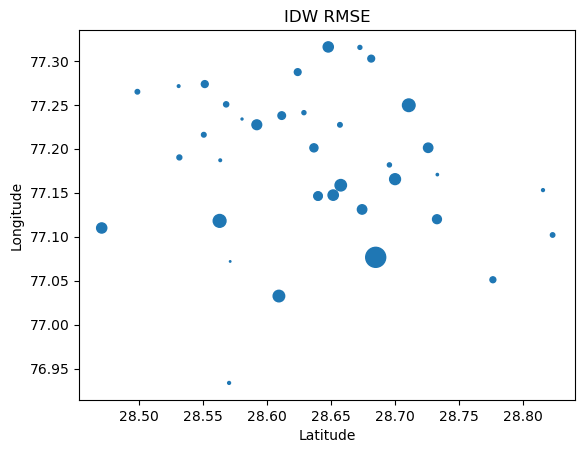

In [35]:
plt.scatter(y = df_results["lon"], x = df_results["lat"], s = df_results["idw rmse"], cmap = "jet")
plt.title('IDW RMSE')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()